In [18]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
from sklearn import preprocessing
import math 
import scipy.stats as ss
plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_19'


measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            ]
measures = ['R_' + i for i in measures]

bigmasks = ['BrainStem','BasalGanglia']#, 'LBrainStem','LBasalGanglia', 'RBrainStem','RBasalGanglia' ]
parameters  = ['EFC_MAG','SNR_MAG', 'CNR_MAG', 'GM',   'WM',  'CSF']

drop_c = ['GSNT', 'TR4T'] #all women scanned for MRS review. GSNT is extra. 
drop_p = [] # motion outliers via mehalonobis distance



In [19]:
def read_df(img, quant, population, study_id):
    df = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)), index_col = 0)
    return df 

qsm_mu_controls_a = read_df('QSM', 'median', 'controls', 'a').drop(drop_c, axis = 0) #* 1000
qsm_mu_controls_b = read_df('QSM', 'median', 'controls', 'b').drop(drop_c, axis = 0) #* 1000

qsm_mu_patients_a = read_df('QSM', 'median', 'patients', 'a').drop(drop_p, axis = 0) #* 1000
qsm_mu_patients_b = read_df('QSM', 'median', 'patients', 'b').drop(drop_p, axis = 0) #* 1000


In [20]:
def run_paired_stats(df1,df2, measures):
    
    trt_index   = ['N','Baseline', 'Retest', 'COV','PDifference', 'PError', 'statistic', 'p_value', 'test_type'] 
    trt_df      = pd.DataFrame(index=trt_index, columns = [measures ])#+ parameters ])
    
    def remove_nans_and_return_tuples(met1,met2):
        vlist = []
        for i in zip(np.array(met1), np.array(met2)):
            vlist.append(i)
        varray = np.array(vlist)
        varray = varray[~np.isnan(varray).any(1)]
        #print varray
        return varray
    
    # Coefficient of Variation
    def calc_cov(tuple_array):
        cov_array = []
        for i in tuple_array:
            cov = (std(i) / mean(i)) * 100
            cov_array.append(cov)
        return np.round(mean(cov_array),2), np.round(std(cov_array),2)

    #Absolute Percentage Difference    
    def calc_percent_diff(tuple_array):
        pd_array=[]
        for i in tuple_array:
                pd = abs((i[0] - i[1]) / (mean(i))) * 100
                pd_array.append(pd)
        return np.round(mean(pd_array),2), np.round(std(pd_array),2)

    # Asbolute Percentage Error  
    def calc_percent_error(tuple_array):
        pe_array = []
        for i in tuple_array:
            pe = abs((i[0]-i[1]) / i[1]) * 100
            pe_array.append(pe)
        return np.round(mean(pe_array),2), np.round(std(pe_array), 2)
    
    def make_paired_ttest(tuple_array):
        #Calculates the T-test on TWO RELATED samples of scores, a and b.
        #This is a two-sided test for the null hypothesis that 2 related or
        #repeated samples have identical average (expected) values.
        m1 = [i[0] for i in tuple_array]
        m2 = [i[1] for i in tuple_array]
        #print len(m1)
        #print len(m2)
        t_value, p_value = ttest_rel(np.array(m1), np.array(m2))
        #t_value, p_value = wilcoxon(np.array(m1), np.array(m2))
        return np.round(t_value, 3), np.round(p_value, 3)
    
    for measure in measures :#+ parameters :
        tuple_array = remove_nans_and_return_tuples(preprocessing.scale(df1[measure]), 
                                                    preprocessing.scale(df2[measure]))
        #print measure, tuple_array
        tuple_array = remove_nans_and_return_tuples(df1[measure],df2[measure])
        statistic, p_value = make_paired_ttest(tuple_array)
        tuple_array = remove_nans_and_return_tuples(df1[measure], df2[measure])
        cov_mean, cov_std = calc_cov(tuple_array)
        pd_mean, pd_std   = calc_percent_diff(tuple_array)
        pe_mean, pe_std   = calc_percent_error(tuple_array)
        
        npr = 2
        xv = 1000
        trt_df.loc['N'][measure]           = len(list(tuple_array))
        trt_df.loc['Baseline'][measure]    = '%s ± %s' %(np.round(np.mean(df1[measure]* xv),npr), 
                                                         np.round(np.std(df1[measure] * xv),npr))
        trt_df.loc['Retest'][measure]      = '%s ± %s' %(np.round(np.mean(df2[measure]* xv),npr), 
                                                         np.round(np.std(df2[measure] * xv),npr))
        trt_df.loc['COV'][measure]         = '%s ± %s' %(np.round(cov_mean,1), np.round(cov_std,1))
        trt_df.loc['PDifference'][measure] = '%s ± %s' %(np.round(pd_mean,1),  np.round(pd_std,1))
        trt_df.loc['PError'][measure]      = '%s ± %s' %(np.round(pe_mean,1), np.round(pe_std,1))
        
        trt_df.loc['statistic'][measure] = np.round(statistic,2)
        trt_df.loc['p_value'][measure]   = np.round(p_value,5)
        trt_df.loc['test_type'][measure] = 'ttest_rel'
    
    return trt_df.T.sort('p_value')

In [21]:
run_paired_stats(qsm_mu_controls_a,qsm_mu_controls_b, measures)

/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,N,Baseline,Retest,COV,PDifference,PError,statistic,p_value,test_type
R_RN,7,118.69 ± 49.11,127.57 ± 31.32,26.6 ± 14.3,53.2 ± 28.6,39.9 ± 18.8,-4.74,0.003,ttest_rel
R_STN,7,67.76 ± 33.85,84.19 ± 28.58,42.6 ± 35.8,85.2 ± 71.7,52.2 ± 30.7,-4.23,0.006,ttest_rel
R_Puta,7,-1.12 ± 18.65,1.85 ± 12.1,-48.3 ± 174.2,286.7 ± 220.2,360.6 ± 273.9,-3.03,0.023,ttest_rel
R_GPe,7,105.96 ± 18.19,102.58 ± 16.97,7.9 ± 7.2,15.8 ± 14.3,18.4 ± 18.6,1.27,0.25,ttest_rel
R_GPi,7,98.14 ± 24.86,95.65 ± 15.84,12.4 ± 9.5,24.8 ± 19.0,29.6 ± 27.2,1.25,0.258,ttest_rel
R_Caud,7,14.96 ± 12.55,10.49 ± 9.5,-8891.2 ± 21608.1,17937.7 ± 43152.0,200.0 ± 236.7,-1.01,0.35,ttest_rel
R_SN,7,128.7 ± 23.55,124.41 ± 26.19,8.3 ± 6.4,16.5 ± 12.9,17.2 ± 14.8,-0.08,0.939,ttest_rel
R_Thal,7,-36.82 ± 13.21,-39.49 ± 15.19,-9.7 ± 7.6,19.4 ± 15.2,21.6 ± 19.5,0.05,0.962,ttest_rel


In [22]:
run_paired_stats(qsm_mu_patients_a,qsm_mu_patients_b, measures)

/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,N,Baseline,Retest,COV,PDifference,PError,statistic,p_value,test_type
R_Puta,12,-3.99 ± 18.73,1.52 ± 19.81,-215.2 ± 511.8,615.5 ± 924.3,144.0 ± 140.5,-1.92,0.081,ttest_rel
R_RN,12,116.12 ± 42.33,102.04 ± 48.62,18.2 ± 9.4,36.3 ± 18.7,37.1 ± 21.2,-1.03,0.324,ttest_rel
R_SN,12,126.82 ± 42.86,113.51 ± 31.66,11.8 ± 11.1,23.5 ± 22.1,27.4 ± 29.3,0.88,0.395,ttest_rel
R_Thal,12,-36.25 ± 13.55,-30.92 ± 11.26,-27.4 ± 23.7,54.9 ± 47.4,75.9 ± 97.9,-0.74,0.473,ttest_rel
R_Caud,12,12.11 ± 10.65,15.89 ± 8.16,62.4 ± 61.3,124.8 ± 122.6,106.3 ± 130.0,-0.65,0.526,ttest_rel
R_STN,12,60.28 ± 35.43,50.35 ± 35.36,47.1 ± 103.7,94.2 ± 207.4,47.2 ± 70.4,-0.56,0.587,ttest_rel
R_GPe,12,105.85 ± 22.73,97.72 ± 23.59,15.1 ± 12.5,30.2 ± 25.1,36.5 ± 42.9,0.36,0.727,ttest_rel
R_GPi,12,97.01 ± 27.62,96.28 ± 16.98,15.2 ± 8.5,30.4 ± 16.9,32.2 ± 21.1,0.33,0.748,ttest_rel


In [23]:
run_paired_stats(qsm_mu_patients_a,qsm_mu_patients_b, bigmasks)

/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,N,Baseline,Retest,COV,PDifference,PError,statistic,p_value,test_type
BrainStem,12,98.68 ± 35.65,89.4 ± 29.78,10.1 ± 7.9,20.1 ± 15.7,20.0 ± 17.2,-0.81,0.433,ttest_rel
BasalGanglia,12,14.64 ± 12.57,17.11 ± 11.79,69.8 ± 82.8,139.5 ± 165.6,119.5 ± 171.0,-0.76,0.463,ttest_rel


In [24]:
def make_plot(df1,df2, m1 = 'STN', m2 = 'SN', m3 = 'RN', pal= [0,3]):
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
    f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
    f.set_size_inches([20,10])
    pallete = sns.color_palette("hls", 10)[pal[0]:pal[1]]
    x = 1000
                
    def make_multiplot(m,  pallete, ax, jitter = 0.2, font=30):   
        data = [df1[m]*x, df2[m]*x] 
        g = sns.violinplot( data = data, color = pallete, ax = ax,whis= 1)
        g = sns.stripplot(data=data, color = pallete, jitter= jitter, ax = ax, size = 10, linewidth=1)
        g = sns.pointplot(data=data, color = pallete, linestyles=['--'], markers=['o'], ax =ax)
        g.legend([m], fontsize = 30 , handlelength=0, loc = 2)
        g.set(xticklabels=['Controls','Patients'])      
        def annot_datapoints(df, m, xr, alpha = 0.2, ax = ax):
            for i,s in zip(df[m]* x, df.index):
                ann = ax.annotate('%s'%s, xy= (xr,i), size= 15, color='b', alpha = alpha)
        
        annot_datapoints(df1,m, -0.4)
        annot_datapoints(df2,m, 0.4)
    
    make_multiplot(m1, pallete[0], ax1)
    make_multiplot(m2, pallete[1], ax2)
    make_multiplot(m3, pallete[2], ax3)


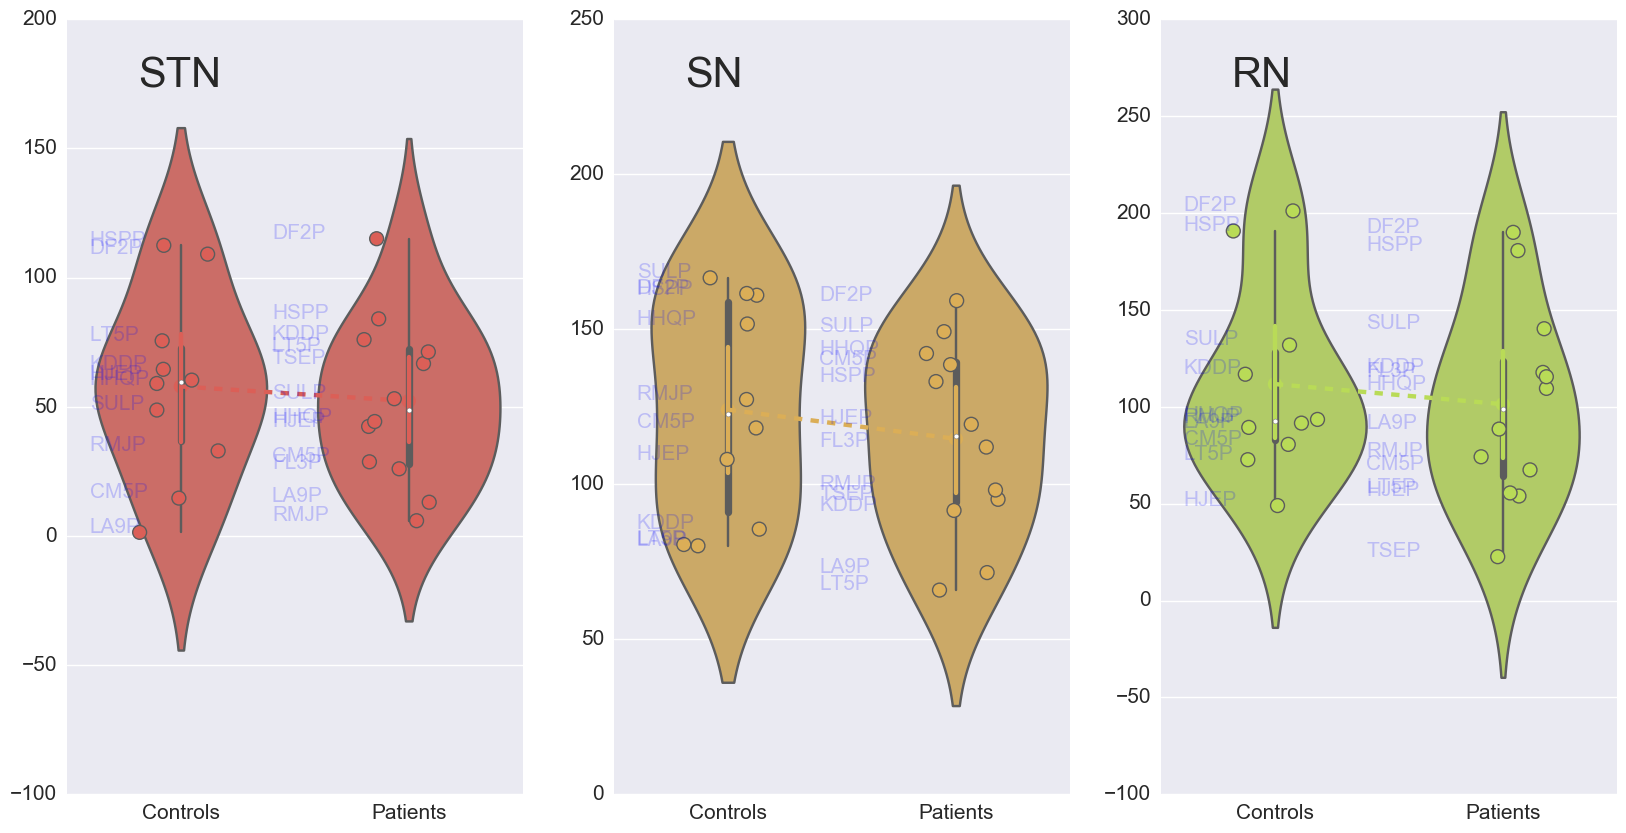

In [25]:
dropa= [i for i in qsm_mu_patients_a.index if i not in qsm_mu_patients_b.index]
make_plot(qsm_mu_patients_a.drop(dropa, axis=0),
          qsm_mu_patients_b,m1 = 'STN', m2 = 'SN', m3 = 'RN')

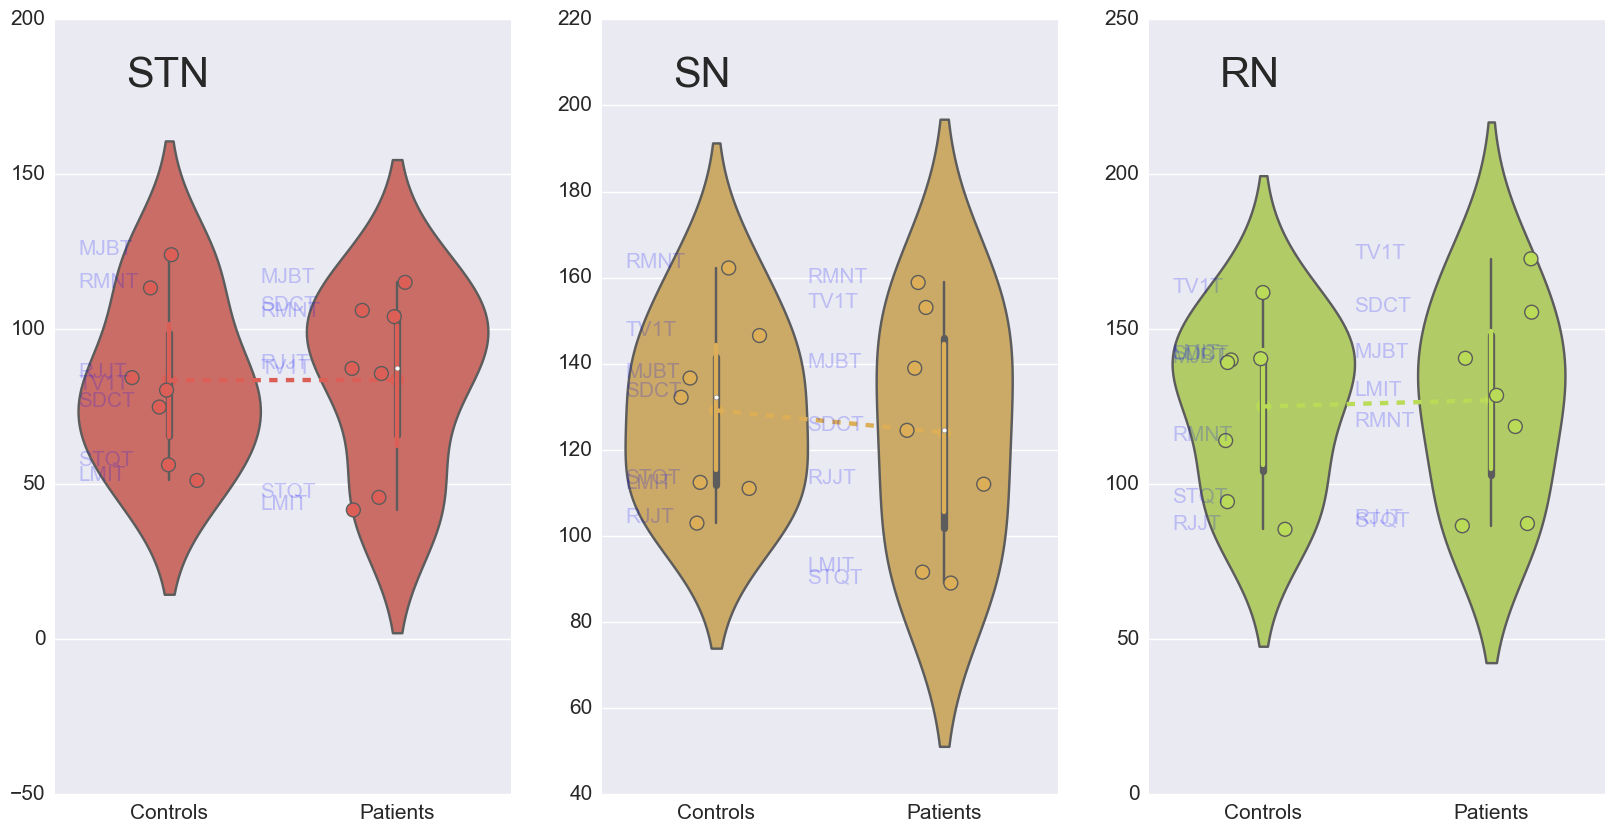

In [26]:
dropa= [i for i in qsm_mu_controls_a.index if i not in qsm_mu_controls_b.index]
make_plot(qsm_mu_controls_a.drop(dropa, axis=0),
          qsm_mu_controls_b,m1 = 'STN', m2 = 'SN', m3 = 'RN')

In [27]:
qsm_mu_controls_b.SN

STQT    0.089057
RJJT    0.112018
SDCT    0.124530
MJBT    0.138960
LMIT    0.091595
TV1T    0.153068
RMNT    0.158866
Name: SN, dtype: float64

In [28]:
qsm_mu_controls_b.BrainStem * 1000

STQT     73.817333
RJJT     95.569333
SDCT    128.716000
MJBT    131.585667
LMIT     87.334000
TV1T    137.175500
RMNT    127.191667
Name: BrainStem, dtype: float64

In [29]:
qsm_mu_controls_b.STN * 1000

STQT     40.962
RJJT     84.380
SDCT    101.781
MJBT    112.212
LMIT     37.631
TV1T     81.790
RMNT    102.309
Name: STN, dtype: float64

In [30]:
qsm_mu_controls_a.STN * 1000

SMVX     35.3085
SS1X     21.5285
STQT     52.7400
HM1X     89.4930
WSKT     -7.5015
FA2T     63.1270
SC1T     21.2140
PAHT     51.6305
LL5T      1.7730
RJJT     78.3550
KO4T    108.2915
SDCT     67.5210
HM2X     76.1075
MJBT    120.8910
GHAT     98.6505
EC9T    106.3615
RA7T     76.9050
PU2T     85.7830
TJ5T     75.7805
BH5T     68.9030
LMIT     49.7820
GSAT     60.6660
TV1T     78.0695
RMNT    108.8945
Name: STN, dtype: float64

In [31]:
qsm_mu_controls_b.STN * 1000

STQT     40.962
RJJT     84.380
SDCT    101.781
MJBT    112.212
LMIT     37.631
TV1T     81.790
RMNT    102.309
Name: STN, dtype: float64

In [32]:
qsm_mu_controls_b.Age

STQT    23
RJJT    36
SDCT    42
MJBT    45
LMIT    53
TV1T    55
RMNT    57
Name: Age, dtype: int64